In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from af22c.proteome import MultipleSeqAlign
import matplotlib.pyplot as plt

In [2]:
prot = MultipleSeqAlign.from_a3m("../data/A0A0A0MRZ7.a3m")

100%|████████████████████████████████████| 9846/9846 [00:00<00:00, 82564.35it/s]


In [3]:
vocab = sorted(list(set("".join([str(prot.query_seq)] + [str(match.aligned_seq) for match in prot.matches]))))
"".join(vocab),len(vocab)

('-ACDEFGHIKLMNPQRSTVWXY', 22)

In [4]:
stoi = {c:i for i, c in enumerate(vocab)}
itos = {i:c for c, i in stoi.items()}

In [5]:
query_len = len(prot.query_seq)
num_matches = len(prot.matches)
num_seqs = num_matches + 1 # include query
query_len,num_matches,num_seqs

(120, 9844, 9845)

In [6]:
encmsa = np.zeros((num_seqs, query_len))
for seqidx, seq in enumerate([prot.query_seq] + [match.aligned_seq for match in prot.matches]):
    for colidx, colval in enumerate(seq):
        encmsa[seqidx, colidx] = stoi[colval]
encmsa.shape

(9845, 120)

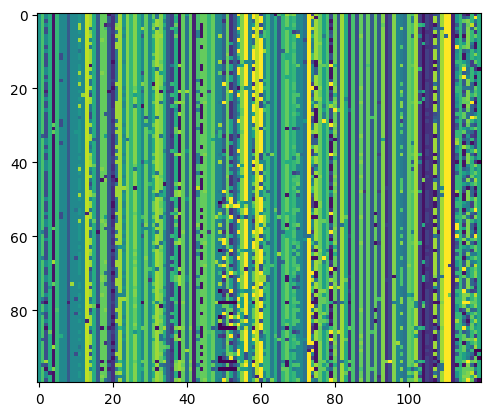

In [7]:
plt.imshow(encmsa[:100])

In [8]:
smallmsa = torch.tensor(encmsa[:10,8:18]) # (num_seqs, query_len)
# adjust variables for toy example
num_seqs, query_len = smallmsa.shape
num_matches = num_seqs - 1

Text(0.5, 0, 'AA index')

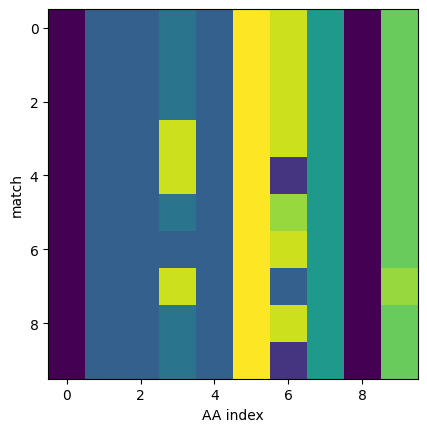

In [9]:
plt.imshow(smallmsa)
plt.ylabel("match")
plt.xlabel("AA index")

In [78]:
# pairwise hamming distances
pwdists = torch.sum(smallmsa[None,:,:] != smallmsa[:,None,:], axis=-1)
# pairwise sequence identities = 1 - normalized hamming distances (each value divided by sequence length)
pwseq = 1 - pwdists / query_len

Text(0, 0.5, 'query seq idx')

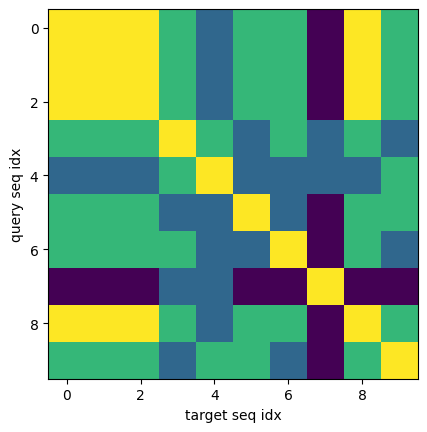

In [79]:
plt.imshow(pwseq)
plt.xlabel("target seq idx")
plt.ylabel("query seq idx")

In [80]:
pwseq[0,0],pwseq[0,3],pwseq[0,4],pwseq[0,7]

(tensor(1.), tensor(0.9000), tensor(0.8000), tensor(0.7000))

with our MSA sizes, it is probably not feasible to run sequence identity checks on the entire MSA. therefore, we need to divide the MSA into smaller batches.

In [81]:
batch_size = 4 # number of sequenes in batch
# calculate all pairs for which pairwise sequence identities need to be calculated
#pairs = torch.cartesian_prod(*(torch.arange(num_seqs),)*2)
pairs = []
for i in range(num_seqs):
    for j in range(i+1, num_seqs):
        pairs.append((i,j))
pairs = torch.tensor(pairs)
pairs.shape

torch.Size([45, 2])

In [82]:
# each batch should yield a matrix with batch_size elements
num_batches = (len(pairs) + batch_size - 1) // batch_size
num_batches

12

In [83]:
# one batch contains batch_size many pairs, which yields batch_size many similarity scores because the 
# similarity matrix is symmetric.
bpwseq = torch.eye(num_seqs) # matrix containing similarity scores for two sequences
for batch_idx in range(num_batches):
    # calculate similarity scores for a batch
    pairs_idx = torch.arange(batch_idx*batch_size, min((batch_idx + 1)*batch_size, len(pairs)))
    batch_pairs = pairs[pairs_idx]

    # calculate sequences in batch
    batch_seqs = torch.zeros((batch_size, 2, query_len))
    for pair_idx, (i, j) in enumerate(batch_pairs):
        # TODO: get rid of float conversion?
        batch_seqs[pair_idx, 0] = smallmsa[i].float()
        batch_seqs[pair_idx, 1] = smallmsa[j].float()

    batch_pwdists = torch.sum(batch_seqs[:,0,:] != batch_seqs[:,1,:], axis=-1)
    batch_pwseq = 1 - batch_pwdists / query_len
    for pair_idx, (i, j) in enumerate(batch_pairs):
        bpwseq[i,j] = pwseq[j,i] = batch_pwseq[pair_idx]
bpwseq

tensor([[1.0000, 1.0000, 1.0000, 0.9000, 0.8000, 0.9000, 0.9000, 0.7000, 1.0000,
         0.9000],
        [0.0000, 1.0000, 1.0000, 0.9000, 0.8000, 0.9000, 0.9000, 0.7000, 1.0000,
         0.9000],
        [0.0000, 0.0000, 1.0000, 0.9000, 0.8000, 0.9000, 0.9000, 0.7000, 1.0000,
         0.9000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.9000, 0.8000, 0.9000, 0.8000, 0.9000,
         0.8000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.8000, 0.8000, 0.8000, 0.8000,
         0.9000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.8000, 0.7000, 0.9000,
         0.9000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.7000, 0.9000,
         0.8000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.7000,
         0.7000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.9000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000]])

In [32]:
batch_pwseqs = []
for batch_idx in range(1,num_batches):
    pair_idx = torch.arange(batch_idx*batch_size, min((batch_idx + 1)*batch_size, len(pairs)))
    batch_pairs = pairs[pair_idx] # (batch_size,2)
    # select sequences from MSA
    required_seqs_idx = batch_pairs.view(-1)
    
    # TODO: write this with one_hot if it becomes a bottleneck
    batch_seqs = torch.zeros((len(required_seqs_idx), query_len))
    for local_idx, seq_idx in enumerate(required_seqs_idx):
        batch_seqs[local_idx] = smallmsa[seq_idx]
    batch_seqs = batch_seqs.view(2,-1,query_len)
    
    # pairwise hamming distances
    batch_pwdists = torch.sum(batch_seqs[0,None,:,:] != batch_seqs[1,:,None,:], axis=-1)
    # pairwise sequence identities = 1 - normalized hamming distances (each value divided by sequence length)
    batch_pwseq = 1 - batch_pwdists / query_len
    batch_pwseqs.append(batch_pwseq)
len(batch_pwseqs)

24

In [19]:
# this only works if all tensors are of the same shape!
if len(batch_pwseqs) > 1:
    assert batch_pwseqs[0].shape == batch_pwseqs[-1].shape
batch_pwseq = torch.stack(batch_pwseqs)
batch_pwseq = batch_pwseq.view(num_seqs,num_seqs)
batch_pwseq.shape

torch.Size([10, 10])

Text(0.5, 1.0, 'complete MSA pairwise seq identity')

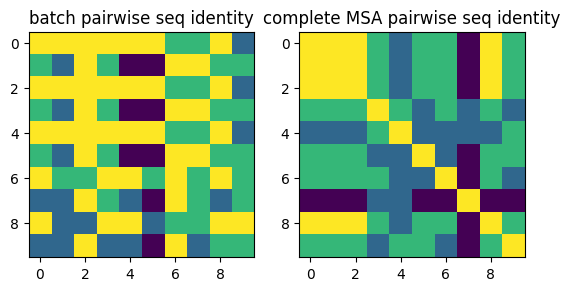

In [17]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
ax1.imshow(batch_pwseq)
ax1.set_title("batch pairwise seq identity")
ax2.imshow(pwseq)
ax2.set_title("complete MSA pairwise seq identity")